<a href="https://colab.research.google.com/github/MadhuhritaSaha/energy-predictor/blob/main/DataCenter3DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_excel('Copy of Energy_consumption(1).xlsx')

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)  # Forward fill for simplicity

# Convert categorical variables to numerical
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})

# Convert 'DayOfWeek' to numerical
df['DayOfWeek'] = df['DayOfWeek'].astype('category').cat.codes

# Convert 'Timestamp' to datetime and extract useful features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

# Drop the original 'Timestamp' column
df.drop('Timestamp', axis=1, inplace=True)

# Split the data into features and target
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

            Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0 2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1 2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2 2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3 2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4 2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

  HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday  \
0        On           Off         2.774699     Monday      No   
1        On            On        21.831384   Saturday      No   
2       Off           Off         6.764672     Sunday      No   
3       Off            On         8.623447  Wednesday      No   
4        On           Off         3.071969     Friday      No   

   EnergyConsumption  
0          75.364373  
1          83.401855  
2          78.270888  
3          56.519850  
4          70.811732  
Timestamp           

<ipython-input-2-f4d9cd9b1924>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill for simplicity


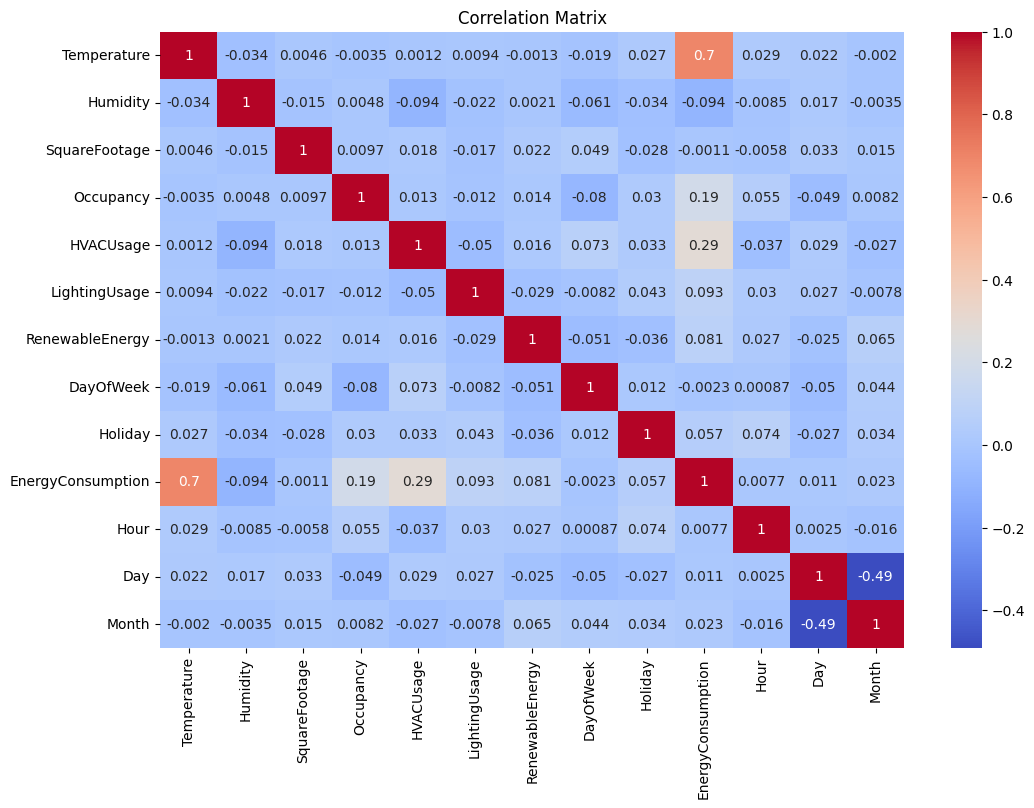

EnergyConsumption    1.000000
Temperature          0.696410
HVACUsage            0.286464
Occupancy            0.186580
LightingUsage        0.093423
RenewableEnergy      0.081160
Holiday              0.056676
Month                0.023197
Day                  0.010825
Hour                 0.007718
SquareFootage       -0.001129
DayOfWeek           -0.002291
Humidity            -0.093583
Name: EnergyConsumption, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Find the correlation of each feature with the target variable
corr_with_target = corr_matrix['EnergyConsumption'].sort_values(ascending=False)
print(corr_with_target)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ARIMA requires a time series, so we'll use the 'EnergyConsumption' column
y_train_series = y_train.values
y_test_series = y_test.values

# Fit ARIMA model
arima_model = ARIMA(y_train_series, order=(5, 1, 0))  # You can tune the order
arima_fit = arima_model.fit()

# Predict
y_pred_arima = arima_fit.forecast(steps=len(y_test_series))

# Evaluate
mae_arima = mean_absolute_error(y_test_series, y_pred_arima)
rmse_arima = np.sqrt(mean_squared_error(y_test_series, y_pred_arima))
r2_arima = r2_score(y_test_series, y_pred_arima)

print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, R2: {r2_arima}')

ARIMA - MAE: 6.578396780709794, RMSE: 8.119301737778116, R2: -0.006460854600119248


In [ ]:
from sklearn.svm import SVR

# Fit SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test)

# Evaluate
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f'SVR - MAE: {mae_svr}, RMSE: {rmse_svr}, R2: {r2_svr}')

SVR - MAE: 4.449691914026705, RMSE: 5.510580863249044, R2: 0.5363884098788627


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Predict
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f'LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}, R2: {r2_lstm}')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5930.9414
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5947.9414
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5922.8237
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5884.8647
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5849.3184
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5720.7324
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5718.4136
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5587.7314
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5398.1875
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5152.5708
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4960.3228 
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4784.7075
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4500.4233
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4219.2520
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

In [ ]:
# Enhanced LSTM with Feature Extractor Gate
# This is a conceptual implementation. You may need to customize it further.

class EnhancedLSTM(tf.keras.Model):
    def __init__(self, units):
        super(EnhancedLSTM, self).__init__()
        self.lstm = LSTM(units, activation='relu', return_sequences=False) # Changed return_sequences to False
        self.dense = Dense(1)
        self.feature_gate = Dense(X_train.shape[1], activation='softmax')

    def call(self, inputs):
        feature_weights = self.feature_gate(inputs)
        weighted_inputs = inputs * feature_weights
        lstm_output = self.lstm(weighted_inputs)
        return self.dense(lstm_output)

# Build and train the enhanced LSTM model
enhanced_lstm_model = EnhancedLSTM(units=50)
enhanced_lstm_model.compile(optimizer='adam', loss='mse')
enhanced_lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Predict
y_pred_enhanced_lstm = enhanced_lstm_model.predict(X_test_lstm)

# Reshape the predictions to match y_test (likely 1D or 2D with single column)
y_pred_enhanced_lstm = y_pred_enhanced_lstm.reshape(y_test.shape) # Reshape to match y_test

# Evaluate
mae_enhanced_lstm = mean_absolute_error(y_test, y_pred_enhanced_lstm)
rmse_enhanced_lstm = np.sqrt(mean_squared_error(y_test, y_pred_enhanced_lstm))
r2_enhanced_lstm = r2_score(y_test, y_pred_enhanced_lstm)

print(f'Enhanced LSTM - MAE: {mae_enhanced_lstm}, RMSE: {rmse_enhanced_lstm}, R2: {r2_enhanced_lstm}')

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5959.2275
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6060.6289
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5992.8237
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5961.4229
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5923.0454
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5848.5254
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5772.1851
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5721.6455
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5546.0762
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5402.5996
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5156.9336
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5029.4248
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4695.6733
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4397.9692
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Enhanced LSTM - MAE: 7.260699705538375, RMSE: 10.443814302535152, R2: -0.6652437320184268


In [ ]:
import xgboost as xgb

# Fit XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}, R2: {r2_xgb}')

XGBoost - MAE: 4.700392559783775, RMSE: 5.723932627075206, R2: 0.4997943973064488


In [ ]:
# Hybrid Model: Enhanced LSTM + XGBoost
# Use the predictions from Enhanced LSTM as features for XGBoost

# Get predictions from Enhanced LSTM
y_pred_enhanced_lstm = enhanced_lstm_model.predict(X_test_lstm).flatten()

# Combine LSTM predictions with original features
X_test_hybrid = np.column_stack((X_test, y_pred_enhanced_lstm))

# **CHANGE:** Create X_train_hybrid with LSTM predictions for training
y_pred_enhanced_lstm_train = enhanced_lstm_model.predict(X_train_lstm).flatten() # Predict on X_train_lstm
X_train_hybrid = np.column_stack((X_train, y_pred_enhanced_lstm_train)) # Combine with X_train

# Fit XGBoost on the hybrid features
xgb_hybrid_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_hybrid_model.fit(X_train_hybrid, y_train)  # **CHANGE:** Train on X_train_hybrid

# Predict
y_pred_hybrid = xgb_hybrid_model.predict(X_test_hybrid)

# Evaluate
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))
r2_hybrid = r2_score(y_test, y_pred_hybrid)

print(f'Hybrid Model - MAE: {mae_hybrid}, RMSE: {rmse_hybrid}, R2: {r2_hybrid}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Hybrid Model - MAE: 4.622588010329307, RMSE: 5.662699894541956, R2: 0.5104392209482526


In [ ]:
# Comparative Analysis
results = {
    'Model': ['ARIMA', 'SVR', 'LSTM', 'Enhanced LSTM', 'XGBoost', 'Hybrid Model'],
    'MAE': [mae_arima, mae_svr, mae_lstm, mae_enhanced_lstm, mae_xgb, mae_hybrid],
    'RMSE': [rmse_arima, rmse_svr, rmse_lstm, rmse_enhanced_lstm, rmse_xgb, rmse_hybrid],
    'R2': [r2_arima, r2_svr, r2_lstm, r2_enhanced_lstm, r2_xgb, r2_hybrid]
}

results_df = pd.DataFrame(results)
print(results_df)

           Model       MAE       RMSE        R2
0          ARIMA  6.578397   8.119302 -0.006461
1            SVR  4.449692   5.510581  0.536388
2           LSTM  9.105633  11.024696 -0.855636
3  Enhanced LSTM  7.260700  10.443814 -0.665244
4        XGBoost  4.700393   5.723933  0.499794
5   Hybrid Model  4.622588   5.662700  0.510439


<ipython-input-13-7589040e736e>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=covariance_with_target.index, y=covariance_with_target.values, palette='viridis')


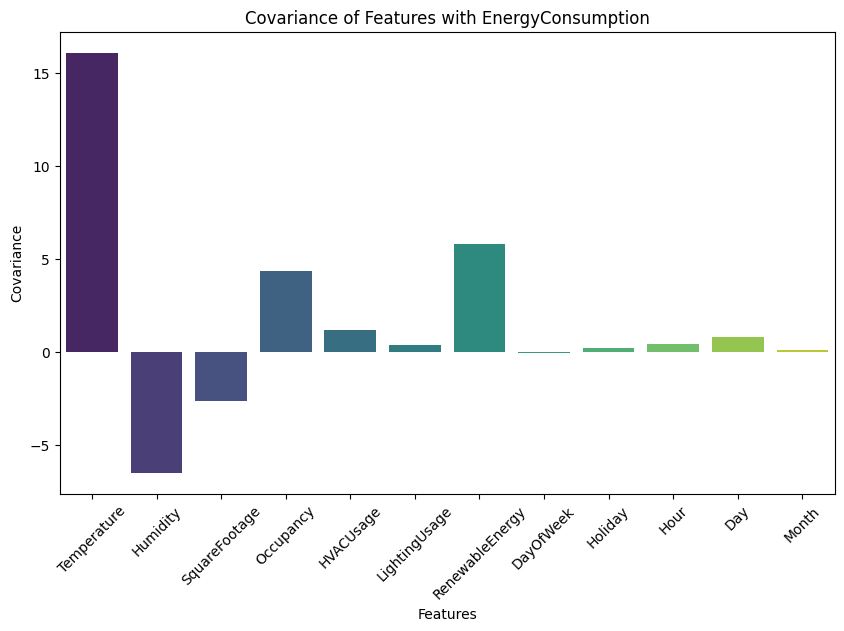

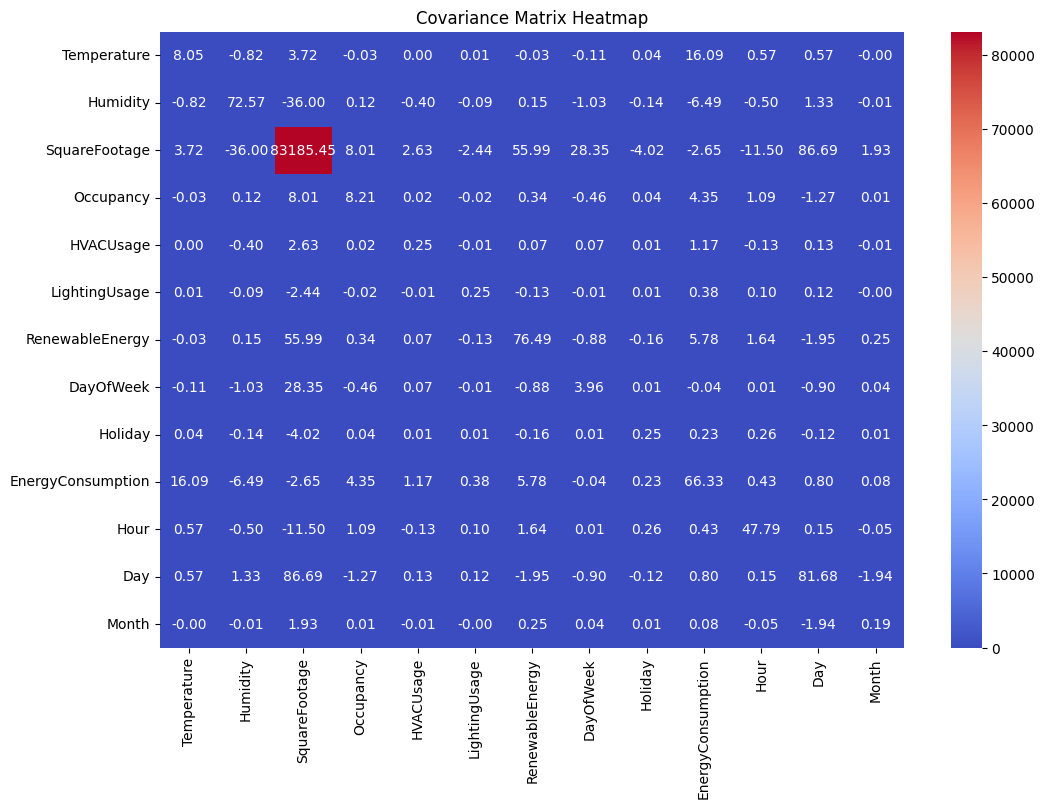

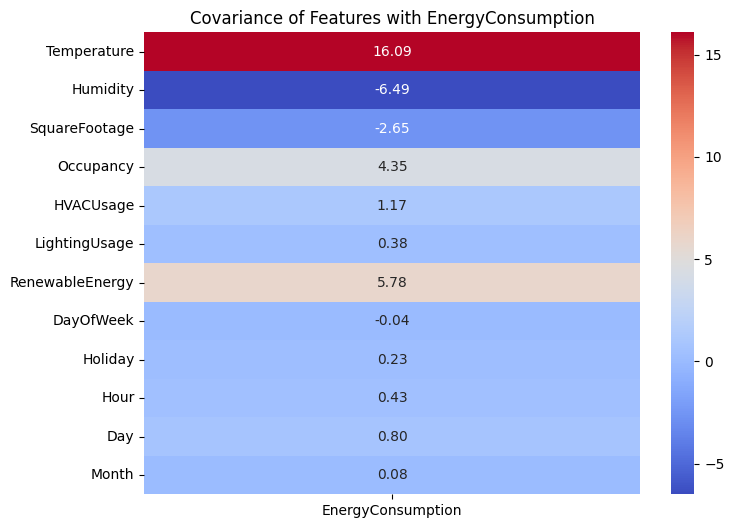

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel('Copy of Energy_consumption(1).xlsx')

# Preprocess the data (if not already done)
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})
df['DayOfWeek'] = df['DayOfWeek'].astype('category').cat.codes
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df.drop('Timestamp', axis=1, inplace=True)

# Calculate covariance of each feature with the target variable
covariance_with_target = df.cov()['EnergyConsumption'].drop('EnergyConsumption')

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=covariance_with_target.index, y=covariance_with_target.values, palette='viridis')
plt.title('Covariance of Features with EnergyConsumption')
plt.xlabel('Features')
plt.ylabel('Covariance')
plt.xticks(rotation=45)
plt.show()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.cov(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance Matrix Heatmap')
plt.show()

# Focused Heatmap (Target Variable Only)
cov_with_target = df.cov()['EnergyConsumption'].drop('EnergyConsumption').to_frame()
plt.figure(figsize=(8, 6))
sns.heatmap(cov_with_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Covariance of Features with EnergyConsumption')
plt.show()

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_excel('Copy of Energy_consumption(1).xlsx')

# Display the first few rows of the dataset
print(df.head())

# Convert categorical variables to numerical (if not already done)
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})

# Convert 'DayOfWeek' to numerical
df['DayOfWeek'] = df['DayOfWeek'].astype('category').cat.codes

# Convert 'Timestamp' to datetime and extract useful features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

# Drop the original 'Timestamp' column
df.drop('Timestamp', axis=1, inplace=True)

# Calculate covariance of each feature with the target variable
covariance_with_target = df.cov()['EnergyConsumption'].drop('EnergyConsumption')

# Display the covariance values
print("Covariance of each feature with EnergyConsumption:")
print(covariance_with_target)

            Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0 2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1 2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2 2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3 2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4 2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

  HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday  \
0        On           Off         2.774699     Monday      No   
1        On            On        21.831384   Saturday      No   
2       Off           Off         6.764672     Sunday      No   
3       Off            On         8.623447  Wednesday      No   
4        On           Off         3.071969     Friday      No   

   EnergyConsumption  
0          75.364373  
1          83.401855  
2          78.270888  
3          56.519850  
4          70.811732  
Covariance of each f

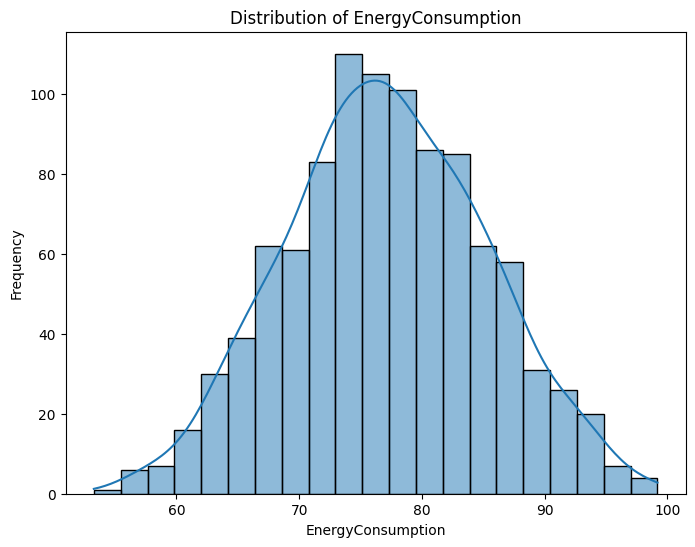

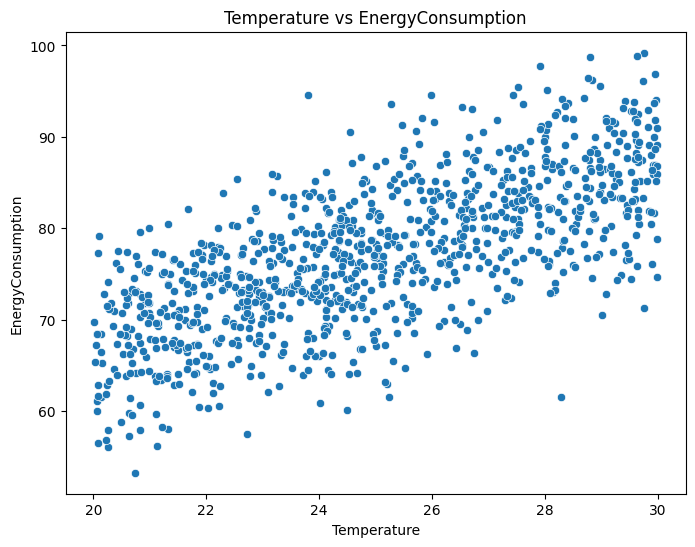

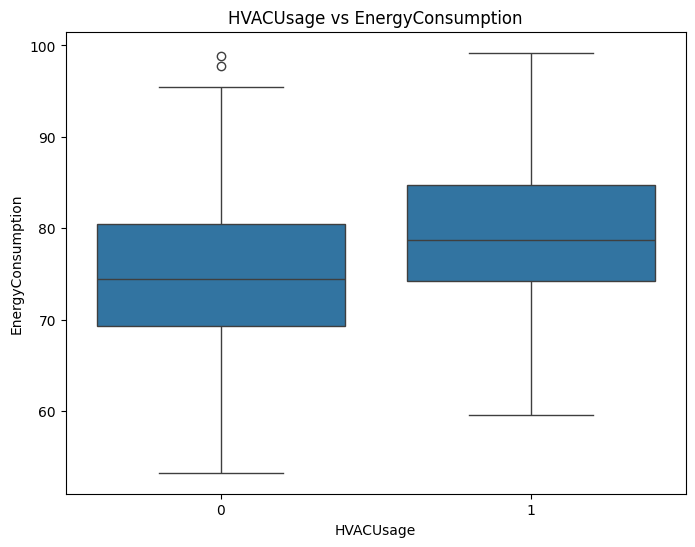

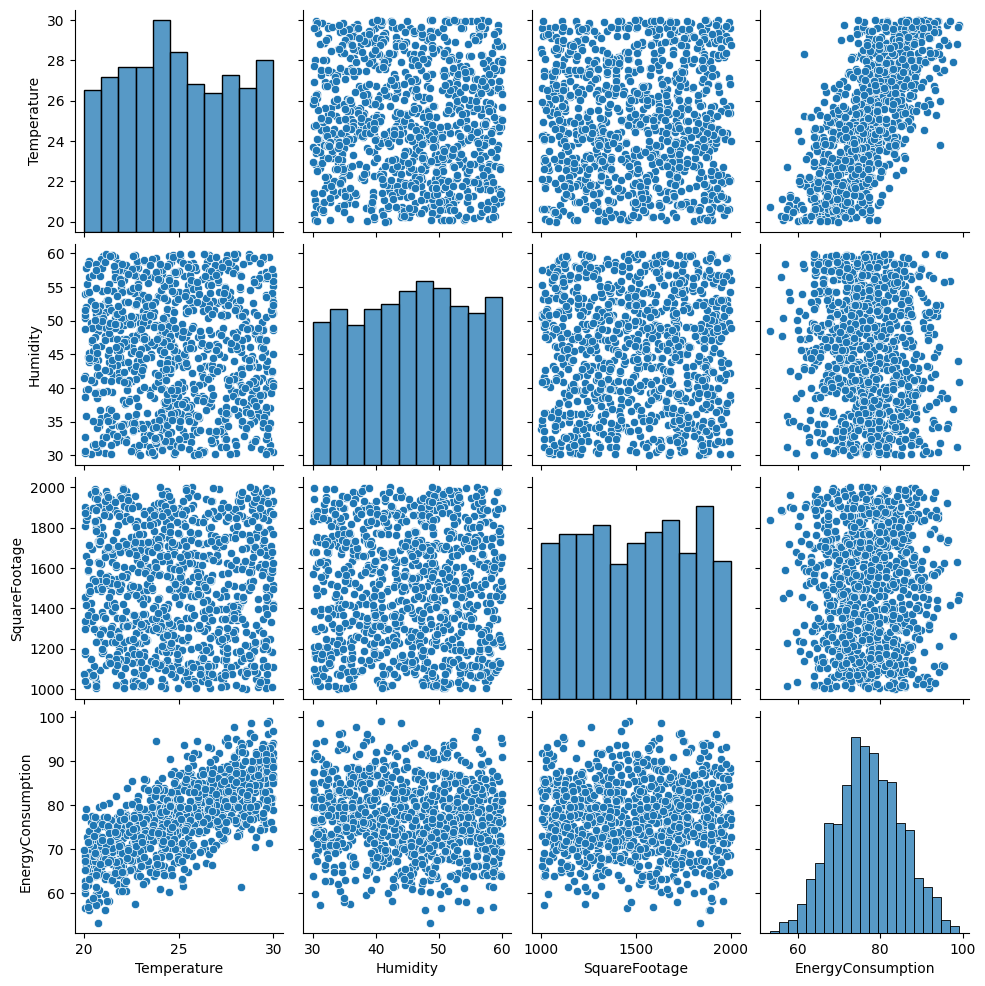

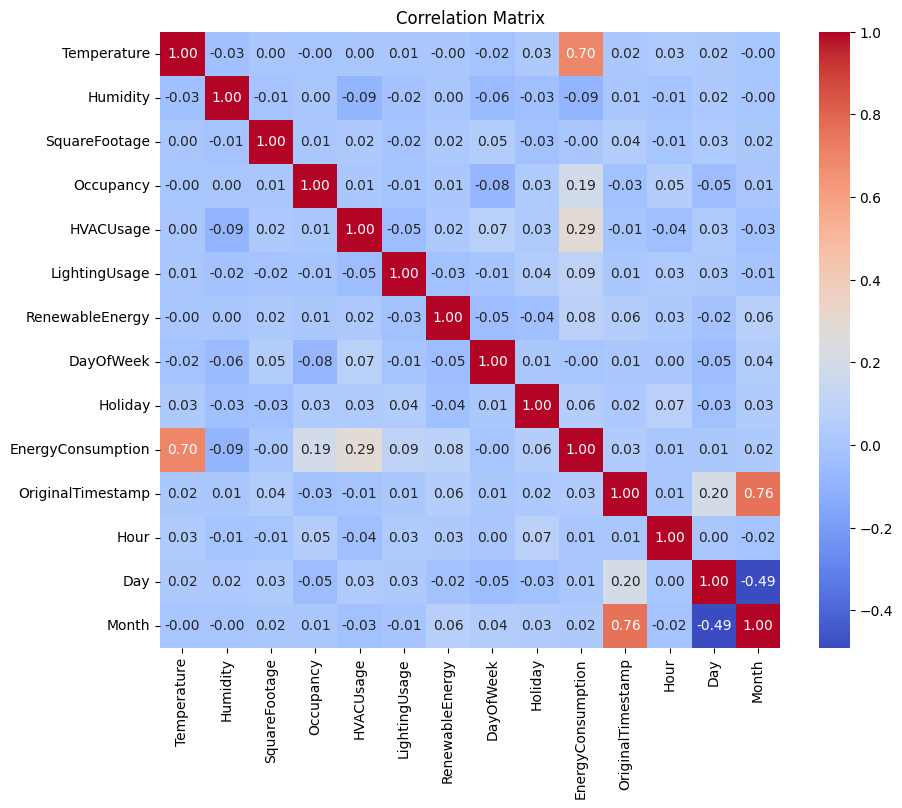

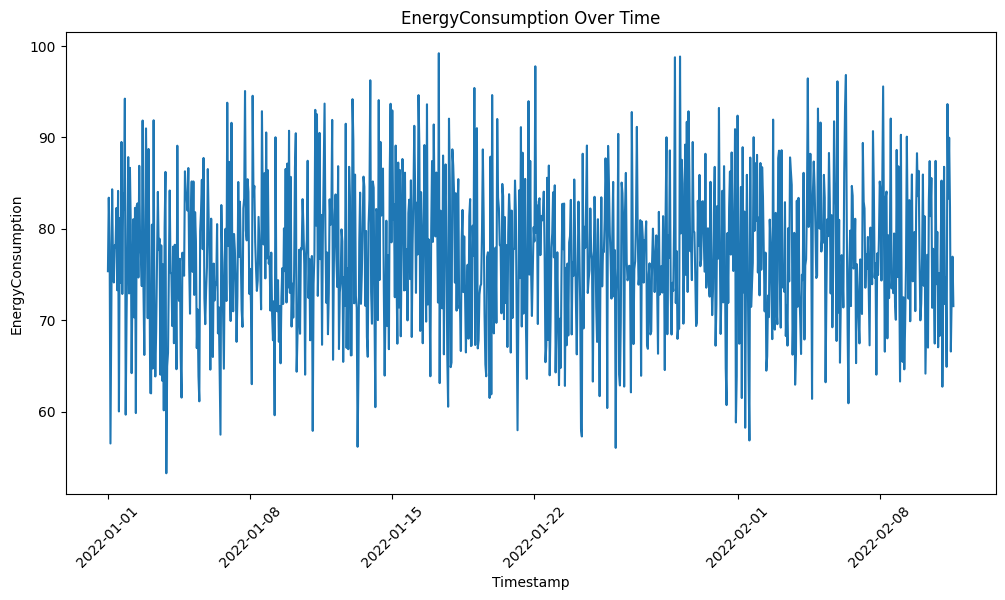

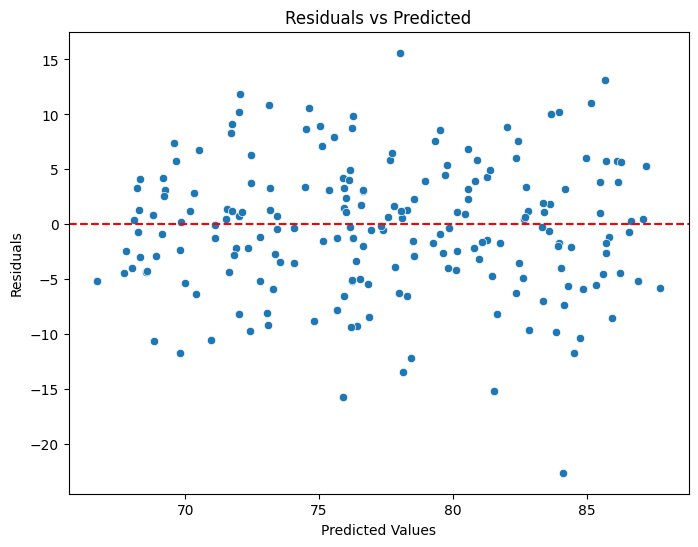

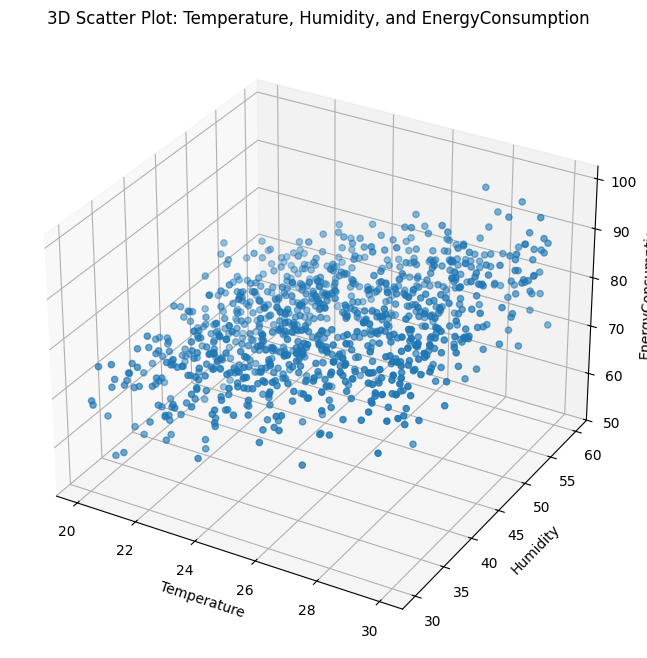

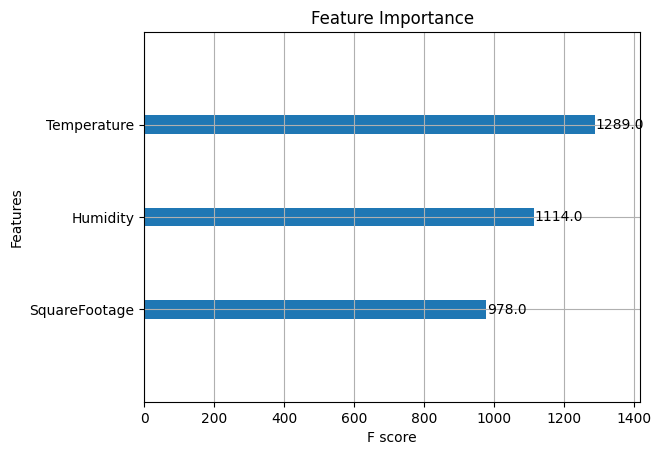

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb

# Load the dataset
df = pd.read_excel('Copy of Energy_consumption(1).xlsx')
# Create a copy of the Timestamp column for plotting later
df['OriginalTimestamp'] = df['Timestamp']

# Preprocess the data (if not already done)
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})
df['DayOfWeek'] = df['DayOfWeek'].astype('category').cat.codes
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df.drop('Timestamp', axis=1, inplace=True)

# 1. Histogram for the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df['EnergyConsumption'], kde=True)
plt.title('Distribution of EnergyConsumption')
plt.xlabel('EnergyConsumption')
plt.ylabel('Frequency')
plt.show()

# 2. Scatter plot for a feature vs target
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Temperature'], y=df['EnergyConsumption'])
plt.title('Temperature vs EnergyConsumption')
plt.xlabel('Temperature')
plt.ylabel('EnergyConsumption')
plt.show()

# 3. Box plot for a categorical feature vs target
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['HVACUsage'], y=df['EnergyConsumption'])
plt.title('HVACUsage vs EnergyConsumption')
plt.xlabel('HVACUsage')
plt.ylabel('EnergyConsumption')
plt.show()

# 4. Pair plot for selected features
sns.pairplot(df[['Temperature', 'Humidity', 'SquareFootage', 'EnergyConsumption']])
plt.show()

# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 6. Line plot for EnergyConsumption over time
plt.figure(figsize=(12, 6))
# Use the 'OriginalTimestamp' column here
sns.lineplot(x=df['OriginalTimestamp'], y=df['EnergyConsumption'])
plt.title('EnergyConsumption Over Time')
plt.xlabel('Timestamp')
plt.ylabel('EnergyConsumption')
plt.xticks(rotation=45)
plt.show()

# 7. Residual plot (after fitting a model)
X = df[['Temperature', 'Humidity', 'SquareFootage']]
y = df['EnergyConsumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 8. 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Temperature'], df['Humidity'], df['EnergyConsumption'])
ax.set_xlabel('Temperature')
ax.set_ylabel('Humidity')
ax.set_zlabel('EnergyConsumption')
plt.title('3D Scatter Plot: Temperature, Humidity, and EnergyConsumption')
plt.show()

# 9. Feature importance plot (XGBoost)
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6032.1846
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5958.6211
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6049.0630
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5983.6748
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5882.5737
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5906.0439
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5786.4326
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5755.7622
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5593.1050
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5445.9043
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5214.5337
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4992.7578
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4675.1646
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4377.7749
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4

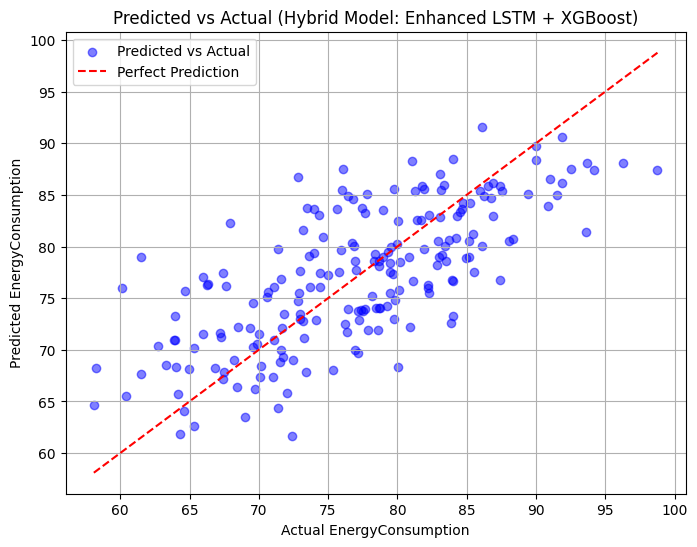

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
import tensorflow as tf # Import tensorflow


# Load the dataset
df = pd.read_excel('Copy of Energy_consumption(1).xlsx')

# Preprocess the data
# Convert categorical variables to numerical
df['HVACUsage'] = df['HVACUsage'].map({'On': 1, 'Off': 0})
df['LightingUsage'] = df['LightingUsage'].map({'On': 1, 'Off': 0})
df['Holiday'] = df['Holiday'].map({'Yes': 1, 'No': 0})
df['DayOfWeek'] = df['DayOfWeek'].astype('category').cat.codes

# Convert 'Timestamp' to datetime and extract useful features
# This line was causing the error because 'Timestamp' was already dropped
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# Instead, create new features directly:
df['Hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['Day'] = pd.to_datetime(df['Timestamp']).dt.day
df['Month'] = pd.to_datetime(df['Timestamp']).dt.month

df.drop('Timestamp', axis=1, inplace=True) # Now you can safely drop 'Timestamp'

# Split the data into features and target
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build and train the Enhanced LSTM model
class EnhancedLSTM(tf.keras.Model):
    def __init__(self, units):
        super(EnhancedLSTM, self).__init__()
        self.lstm = LSTM(units, activation='relu', return_sequences=True)
        self.dense = Dense(1)
        self.feature_gate = Dense(X_train.shape[1], activation='softmax')

    def call(self, inputs):
        feature_weights = self.feature_gate(inputs)
        weighted_inputs = inputs * feature_weights
        lstm_output = self.lstm(weighted_inputs)
        return self.dense(lstm_output)

enhanced_lstm_model = EnhancedLSTM(units=50)
enhanced_lstm_model.compile(optimizer='adam', loss='mse')
enhanced_lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Get predictions from Enhanced LSTM for both training and testing data
y_pred_enhanced_lstm_train = enhanced_lstm_model.predict(X_train_lstm).flatten()
y_pred_enhanced_lstm_test = enhanced_lstm_model.predict(X_test_lstm).flatten()

# Combine LSTM predictions with original features for XGBoost (both training and testing)
X_train_hybrid = np.column_stack((X_train, y_pred_enhanced_lstm_train))
X_test_hybrid = np.column_stack((X_test, y_pred_enhanced_lstm_test))

# Train XGBoost on the hybrid features (using X_train_hybrid)
xgb_hybrid_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_hybrid_model.fit(X_train_hybrid, y_train)

# Predict using the Hybrid Model (using X_test_hybrid)
y_pred_hybrid = xgb_hybrid_model.predict(X_test_hybrid)


# Plot Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_hybrid, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual (Hybrid Model: Enhanced LSTM + XGBoost)')
plt.xlabel('Actual EnergyConsumption')
plt.ylabel('Predicted EnergyConsumption')
plt.legend()
plt.grid(True)
plt.show()

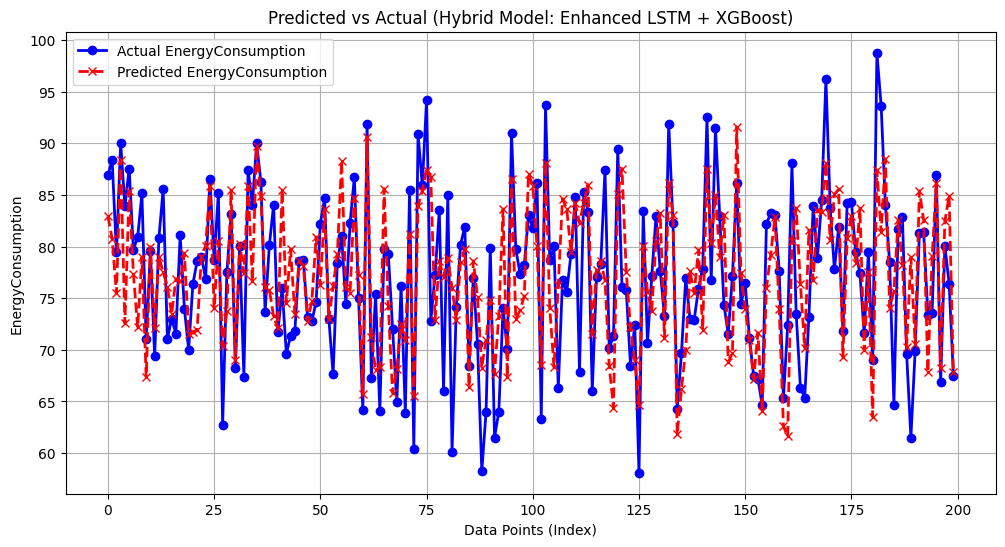

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already trained the Hybrid Model and obtained predictions
# y_test: Actual values
# y_pred_hybrid: Predicted values from the Hybrid Model

# Create a line graph for Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual EnergyConsumption', color='blue', marker='o', linestyle='-', linewidth=2)
plt.plot(y_pred_hybrid, label='Predicted EnergyConsumption', color='red', marker='x', linestyle='--', linewidth=2)
plt.title('Predicted vs Actual (Hybrid Model: Enhanced LSTM + XGBoost)')
plt.xlabel('Data Points (Index)')
plt.ylabel('EnergyConsumption')
plt.legend()
plt.grid(True)
plt.show()